**This file represents the final Pytorch implementation for training and evaluating our final model**

Import

In [1]:
import torch
from torch import optim
from torch import nn
from torchvision import transforms, models
from tqdm import tqdm
from torchmetrics import Accuracy, Precision, Recall
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os
import random
import numpy as np
from MultiStreamResNet import MultiStreamResNet #Import from other file
from MultiModalDataset import get_dataloaders #Import from other file

General configuratio, reproducibility and device, like previous files

In [2]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

NUM_CLASSES = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.0005 # Lower Learning rate
NUM_EPOCHS = 20
IMG_SIZE = 128
VAL_SPLIT_RATIO = 0.20
MODEL_SAVE_PATH = 'multimodal_resnet_fusion.pth'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


General path

In [3]:
base_dir = r'C:\Users\franc\Desktop\data science\PRIMO ANNO\python\final project'
spec_train_dir = os.path.join(base_dir, r'Dataset_Spectrogram\train')
spec_test_dir = os.path.join(base_dir, r'Dataset_Spectrogram\test')
wave_train_dir = os.path.join(base_dir, r'Dataset_Waveform\train')
wave_test_dir = os.path.join(base_dir, r'Dataset_Waveform\test')

Data transforms: same for each stream

In [4]:
standard_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Function to evaluate each single epoch

In [5]:
def validate_epoch(model, dataloader, device):
    model.eval()
    acc_metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
    with torch.no_grad():
        for spec_data, wave_data, targets in dataloader:
            spec_data, wave_data, targets = spec_data.to(device), wave_data.to(device), targets.to(device)
            outputs = model(spec_data, wave_data) # Doppia chiamata
            _, preds = torch.max(outputs, 1)
            acc_metric.update(preds, targets)
    return acc_metric.compute().item()

Test on the model

In [6]:
def test_model(model, dataloader, device, class_names):
    acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
    precision = Precision(task="multiclass", num_classes=NUM_CLASSES, average='macro', zero_division=0).to(device)
    recall = Recall(task="multiclass", num_classes=NUM_CLASSES, average='macro', zero_division=0).to(device)

    model.eval()
    all_preds = []
    all_labels = []

    print("\n--- Starting final evaluation ---")

    with torch.no_grad():
        for spec_data, wave_data, labels in tqdm(dataloader, desc="Testing Multi-Stream"):

            spec_data = spec_data.to(device)
            wave_data = wave_data.to(device)
            labels = labels.to(device)

            outputs = model(spec_data, wave_data)

            _, preds = torch.max(outputs, 1)

            acc.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = acc.compute().item()
    test_precision = precision.compute().item()
    test_recall = recall.compute().item()

    # Stampa dei risultati
    print("\n--- Results ---")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Macro Precision: {test_precision:.4f}")
    print(f"Test Macro Recall: {test_recall:.4f}")

    print("\n--- Classification Report (Test Set) ---")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    #Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.title('Confusion matrix')
    plt.show()

    return test_accuracy

Final exectution

Inizializzazione architettura Multi-Stream...
Configurazione di ResNet18 come Feature Extractor...
Configurazione di ResNet18 come Feature Extractor...

--- Starting training ---


Epoch 1/20: 100%|██████████| 120/120 [11:18<00:00,  5.66s/it]


Loss: 1.0383 | Val Acc: 0.6761
 New record! Val Acc: 0.6761 <<<


Epoch 2/20: 100%|██████████| 120/120 [10:19<00:00,  5.16s/it]


Loss: 0.5700 | Val Acc: 0.8213
 New record! Val Acc: 0.8213 <<<


Epoch 3/20: 100%|██████████| 120/120 [11:04<00:00,  5.54s/it]


Loss: 0.3513 | Val Acc: 0.8433
 New record! Val Acc: 0.8433 <<<


Epoch 4/20: 100%|██████████| 120/120 [14:36<00:00,  7.30s/it]


Loss: 0.2844 | Val Acc: 0.8558
 New record! Val Acc: 0.8558 <<<


Epoch 5/20: 100%|██████████| 120/120 [17:21<00:00,  8.68s/it]


Loss: 0.2184 | Val Acc: 0.8725
 New record! Val Acc: 0.8725 <<<


Epoch 6/20: 100%|██████████| 120/120 [11:30<00:00,  5.76s/it]


Loss: 0.1519 | Val Acc: 0.8433


Epoch 7/20: 100%|██████████| 120/120 [08:46<00:00,  4.39s/it]


Loss: 0.1613 | Val Acc: 0.8955
 New record! Val Acc: 0.8955 <<<


Epoch 8/20: 100%|██████████| 120/120 [08:49<00:00,  4.41s/it]


Loss: 0.1391 | Val Acc: 0.9175
 New record! Val Acc: 0.9175 <<<


Epoch 9/20: 100%|██████████| 120/120 [08:49<00:00,  4.41s/it]


Loss: 0.0807 | Val Acc: 0.9143


Epoch 10/20: 100%|██████████| 120/120 [08:50<00:00,  4.42s/it]


Loss: 0.0907 | Val Acc: 0.8621


Epoch 11/20: 100%|██████████| 120/120 [08:53<00:00,  4.45s/it]


Loss: 0.1082 | Val Acc: 0.9195
 New record! Val Acc: 0.9195 <<<


Epoch 12/20: 100%|██████████| 120/120 [08:49<00:00,  4.41s/it]


Loss: 0.1075 | Val Acc: 0.8631


Epoch 13/20: 100%|██████████| 120/120 [08:50<00:00,  4.42s/it]


Loss: 0.0851 | Val Acc: 0.9289
 New record! Val Acc: 0.9289 <<<


Epoch 14/20: 100%|██████████| 120/120 [08:49<00:00,  4.41s/it]


Loss: 0.0676 | Val Acc: 0.8579


Epoch 15/20: 100%|██████████| 120/120 [08:50<00:00,  4.42s/it]


Loss: 0.0727 | Val Acc: 0.9258


Epoch 16/20: 100%|██████████| 120/120 [08:50<00:00,  4.42s/it]


Loss: 0.0830 | Val Acc: 0.9070


Epoch 17/20: 100%|██████████| 120/120 [08:51<00:00,  4.43s/it]


Loss: 0.0674 | Val Acc: 0.9060


Epoch 18/20: 100%|██████████| 120/120 [09:16<00:00,  4.64s/it]


Loss: 0.0951 | Val Acc: 0.9206


Epoch 19/20: 100%|██████████| 120/120 [08:56<00:00,  4.47s/it]


Loss: 0.0425 | Val Acc: 0.9310
 New record! Val Acc: 0.9310 <<<


Epoch 20/20: 100%|██████████| 120/120 [08:52<00:00,  4.44s/it]


Loss: 0.0370 | Val Acc: 0.9352
 New record! Val Acc: 0.9352 <<<

--- Starting final evaluation ---


Testing Multi-Stream: 100%|██████████| 38/38 [01:08<00:00,  1.79s/it]



--- Results ---
Test Accuracy: 0.8040
Test Macro Precision: 0.8071
Test Macro Recall: 0.8040

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

       blues       0.80      0.78      0.79       120
   classical       0.97      0.94      0.96       120
     country       0.78      0.77      0.78       119
       disco       0.88      0.70      0.78       120
      hiphop       0.85      0.82      0.83       120
        jazz       0.73      0.84      0.78       120
       metal       0.84      0.90      0.87       120
         pop       0.80      0.82      0.81       120
      reggae       0.74      0.83      0.78       120
        rock       0.68      0.63      0.66       120

    accuracy                           0.80      1199
   macro avg       0.81      0.80      0.80      1199
weighted avg       0.81      0.80      0.80      1199



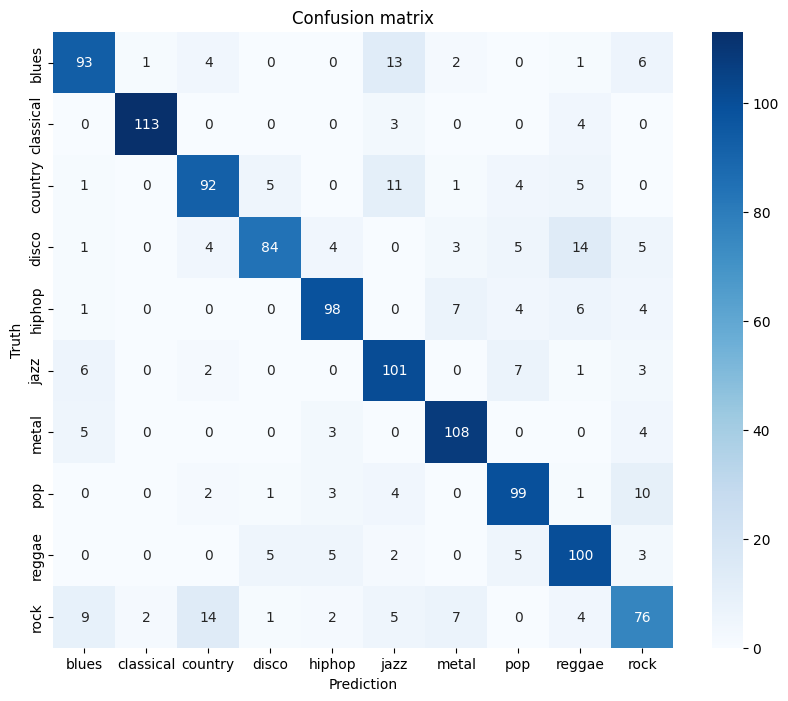


Training DONE.


In [7]:
if __name__ == '__main__':
    set_seed(42)
    train_loader, validation_loader, test_loader, class_names = get_dataloaders(
        spec_train_dir=spec_train_dir, wave_train_dir=wave_train_dir,
        spec_test_dir=spec_test_dir, wave_test_dir=wave_test_dir,
        spec_transforms=standard_transforms, wave_transforms=standard_transforms,
        batch_size=BATCH_SIZE, val_split_ratio=VAL_SPLIT_RATIO
    )

    model = MultiStreamResNet(NUM_CLASSES, DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    best_val_acc = 0.0

    print("\n--- Starting training ---")

    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_loss = 0.0

        for spec_data, wave_data, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}"):
            spec_data, wave_data, targets = spec_data.to(DEVICE), wave_data.to(DEVICE), targets.to(DEVICE)

            scores = model(spec_data, wave_data)
            loss = criterion(scores, targets)

            optimizer.zero_grad(); loss.backward(); optimizer.step();
            epoch_loss += loss.item() * targets.size(0)

        total_train_loss = epoch_loss / len(train_loader.dataset)
        val_acc = validate_epoch(model, validation_loader, DEVICE)

        print(f"Loss: {total_train_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f" New record! Val Acc: {best_val_acc:.4f} <<<")

    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    test_model(model, test_loader, DEVICE, class_names)
    print("\nTraining DONE.")